Make spatial plots of predicted melt data
===

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid, cm
import numpy as np
import math

import pandas as pd
from model import Model
from plotUtils import PlotUtils
# import numpy as np
# from scipy import stats
# import os
# import seaborn as sns
# import matplotlib.ticker as ticker
# from matplotlib.lines import Line2D
# from matplotlib.text import Text

# from GCNet import GCNet

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

import matplotlib.colors as colors

Spatial bounds
---

In [2]:
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5

midLat = (minLat + maxLat) / 2
midLon = (minLon  +maxLon) / 2

print "Latitudes", minLat,minLat,maxLat
print "Longitudes", minLon,midLon,maxLon

Latitudes 58 58 86.5
Longitudes 290 317 345


Function: Load data
---

In [3]:
def loadData( model, branch, ens, mon, suff, predVar = "tas" ):
    if branch == "historical":
        yr1 = "1996"
        yr2 = "2005"

    if branch in ( "rcp85", "1pt5degC"):
        yr1 = "2071"
        yr2 = "2080"

    try:
        mms = "%02d" % mon
    except:
        mms = mon

    if model == "cesmlw":
        enss = "011"
    else:
        try:
            enss = "%03d" % ens
        except:
            enss = ens

    yrs = yr1+"-"+yr2
    
    modelDataDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_%s" % model
    readVar = "melt"
    if "cesm" in model:
        if suff is None:
            modelDataFN = "wrf_%s_%s_%s_newmelt_%s_%s.nc" % ( model, enss, predVar, yrs, mms )
        else:
            modelDataFN = "wrf_%s_%s_%s_newmelt_%s_%s_adj.nc" % ( model, enss, predVar, yrs, mms )
    else:
        modelDataFN = "wrf_%s_%s_newmelt_%s_%s.nc" % ( model, predVar, yrs, mms )
    
    if model == "melt":
        modelDataDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        modelDataFN = "Mote_%s_%s.nc" % ( yrs, mms )
        readVar = "greenland_surface_melt"
    
    print modelDataFN
    D = Model(None, modelDataDir+"/"+modelDataFN)
    X = np.array( D.loadData( readVar ) )
    
    if model == "melt":
        Xf = X.astype(float)
        id = ( X < 0 )
#         Xf[id] = np.nan
        Xf[id] = 0
        X = Xf

    return X, yrs, mms

Function: Create title
---

In [4]:
def createTitle( model, branch, mms ):
    months = dict( [ \
                      ( 'JJA', "JJA" ), \
                      ( '06', "Jun" ), \
                      ( '07', "Jul" ), \
                      ( '08', "Aug" ), \
                   ] )
    
    branches = dict( [ \
                      ( 'historical', "Historical" ), \
                      ( 'rcp85', "RCP 8.5" ), \
                      ( '1pt5degC', "1.5 $^\circ$C" ), \
                   ] )
    
    if model == "melt":
        modelStr = "Obs"
    else:
        modelStr = model.upper()
    try:
        monStr = months[mms]
    except:
        monStr = mms
    try:
        branchStr = branches[branch]
    except:
        branchStr = branch
    
    titleStr = modelStr+" "+branchStr+" "+monStr
    
    return titleStr

Function: create colorbar
---

In [5]:
def createColorBar( cs, cbtitle, axes, loc = 'bottom', format = None ):
    cbshrink = 0.8
    cbdy = 0.04
    
    if format is None:
        cbar = fig.colorbar(cs, location=loc,  ax=axes.ravel().tolist(), \
                            shrink = cbshrink);
    else:
        cbar = fig.colorbar(cs, location=loc,  ax=axes.ravel().tolist(), \
                            shrink = cbshrink, format=format);
    
    cbar.ax.set_xlabel(cbtitle, fontsize=18)
    pos1 = cbar.ax.get_position()
    pos2 = [pos1.x0, pos1.y0+cbdy, pos1.x1*cbshrink, pos1.y1+cbdy]
    cbar.ax.set_position( pos2 )
    
    imaxes = plt.gca()
    plt.sca(cbar.ax)
    plt.xticks(fontsize=16)
    plt.sca(imaxes)

Function: "Normalize" function to center a colorbar on a specific value
---

In [6]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

Global data
---

In [7]:
gFile = "wrf_geog.nc"
G = Model( None, gFile )
lat = np.array( G.loadData( "lat" ) )
nLat = len(lat)
lon = np.array( G.loadData( "lon" ) )
nLon = len(lon)

doCN = 1  # add single contour?
cnSuff = "_cn"

# mon = 6
# mon = 7
# mon = 8
mon = "JJA"

ens = "ens"
# ens = 1

Setup plotting
---

In [8]:
plotStr = "amsmelt"
plotOptions = { "saveFigure": False }
# plotOptions = { "saveFigure": True }

P = PlotUtils( plotOptions )

Load Mote ice sheet mask
---

In [9]:
fn = "icesheet_mask.nc"
ncfn = Dataset(fn, "r")
icemask2d = np.array( ncfn.variables[ "icemask" ] )

Load data
---

In [10]:
predVar = "tas"
# predVar = "tasmax"

models = ( "melt", "erai", "cesmle", "cesmle", "cesmlw" )
branches = ( "historical", "historical", "historical", "rcp85", "1pt5degC" )
# models = ( "melt", "erai" )
# branches = ( "historical", "historical" )

index = 0
for model, branch in zip( models, branches ):
    M, yrs, mms = loadData( model, branch, ens, mon, "adj", predVar )
    nRec, nLat, nLon = M.shape
    if model == "melt":   # Mote obs data
        icemask3d = np.repeat( icemask2d[None,:,:],nRec,axis=0)
        noice = (icemask3d < 1)
        M[noice] = np.nan
    if index == 0:
        melt = np.empty( [len(models), nRec, nLat, nLon] )
        meltSum = np.empty( [len(models), nLat, nLon] )

    melt[index,:,:,:] = M
    meltSum[index,:,:] = np.sum( M, axis = 0 )
   
    index += 1

# issues with "_FillValue" mean there are some VERY large negative values in meltSum,
# so let's change those to nan.
nodata = (meltSum < 0)
meltSum[nodata] = np.nan

# calculate melt fraction
meltFrac = meltSum / nRec * 100.

# ...and how many models were there?
nModels = meltSum.shape[0]

Mote_1996-2005_JJA.nc
wrf_erai_tas_newmelt_1996-2005_JJA.nc
wrf_cesmle_ens_tas_newmelt_1996-2005_JJA_adj.nc
wrf_cesmle_ens_tas_newmelt_2071-2080_JJA_adj.nc
wrf_cesmlw_ens_tas_newmelt_2071-2080_JJA_adj.nc


/Library/Python/2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


Plot melt sum, i.e., how many days did melt occur
---

Saving figure to wrf_amsmelt_tas_meltSum.eps


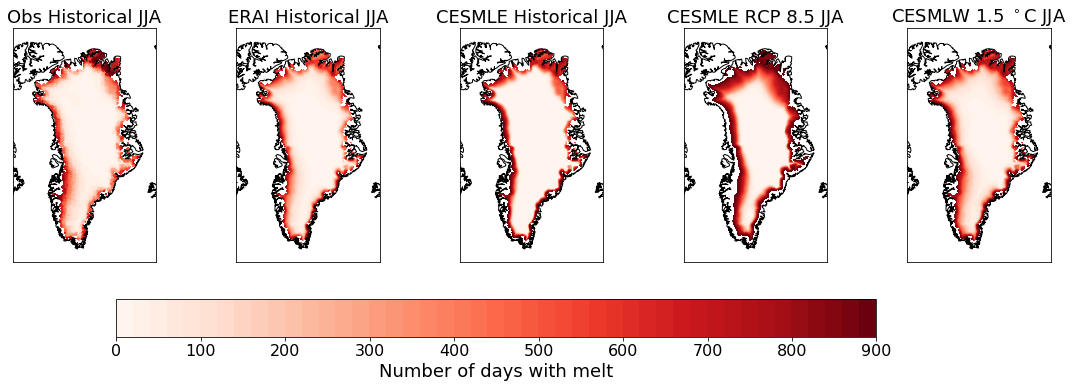

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[index,:,:], cLev, cmap = plt.get_cmap("Reds"))
    axesF[index].set_title( createTitle( models[index], branches[index], mms ),  fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Number of days with melt', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum" )

Plot melt fraction, i.e., what fraction of period did melt occur
---

Saving figure to wrf_amsmelt_tas_meltFrac.eps


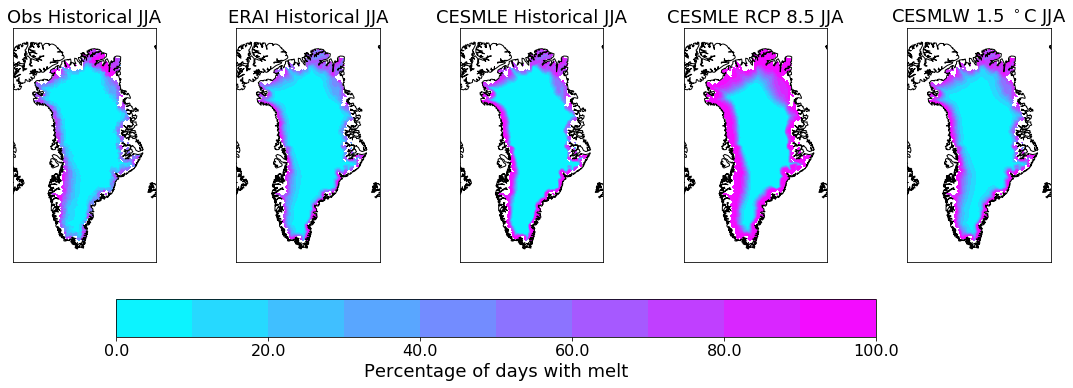

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

cLev = np.linspace( 0., 100., 11 )
# cLev = np.linspace( 0., np.nanmax( meltFrac), 20 )
for index in range(meltSum.shape[0]):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[index,:,:], cLev, cmap = plt.get_cmap("cool"))
#     cbar = m.colorbar(cs,location='right',pad="5%")
    axesF[index].set_title( createTitle( models[index], branches[index], mms ), fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Percentage of days with melt', axes, 'bottom', "%0.1f" )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac" )

Historical only: Plot melt sum, i.e., how many days did melt occur
---

Saving figure to wrf_amsmelt_tas_meltSum_historical.eps


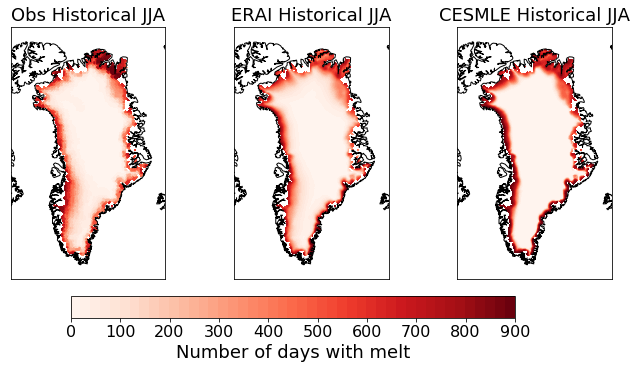

In [13]:
doCN = 0  # add single contour?
cLev2 = 80
mdlIndex = (0,1,2)
meltSum2 = meltSum[mdlIndex,:,:]
meltFrac2 = meltFrac[mdlIndex,:,:]
nModels = meltSum2.shape[0]

fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds"))
    if doCN:
        cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Number of days with melt', axes )

if doCN:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_historical"+cnSuff )
else:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_historical" )

Show differences
---

Saving figure to wrf_amsmelt_tas_meltSum_historical_diff.eps


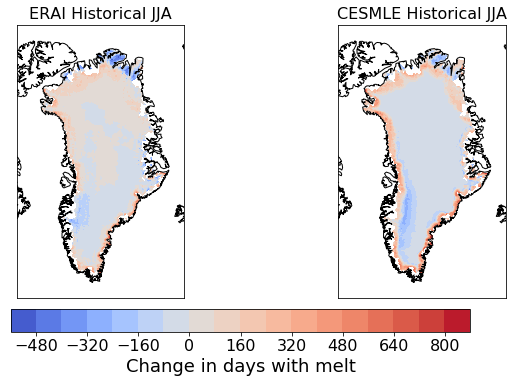

In [14]:
nModels = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
axesF = axes.flat
refMelt = meltSum[0,:,:]
mdlIndex = (1,2)

# cLev = np.linspace( 0, nRec, 20 )
# cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    dMelt = meltSum[mdlIndex[index],:,:] - refMelt
    cs = m.contourf(x, y, dMelt, 20, cmap = plt.get_cmap("coolwarm"), norm=MidpointNormalize(midpoint=0.))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Change in days with melt', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_historical_diff" )

Historical only: Plot melt fraction, i.e., what fraction of period did melt occur
---

Saving figure to wrf_amsmelt_tas_meltFrac_historical.eps


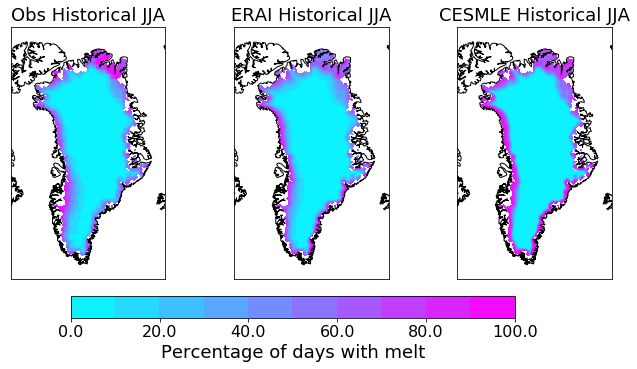

In [106]:
doCN = 0  # add single contour?
nModels = meltSum2.shape[0]
mdlIndex = (0,1,2)
cLev2 = 0.3
fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

# cLev = np.linspace( 0., np.nanmax( meltFrac), 20 )
cLev = np.linspace( 0., 100., 11 )
for index in range(nModels):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("cool"))
    if doCN:
        cn = m.contour(x, y, meltFrac[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ), fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Percentage of days with melt', axes, 'bottom', "%0.1f" )

if doCN:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_historical"+cnSuff )
else:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_historical" )

Show differences
---

Saving figure to wrf_amsmelt_tas_meltFrac_historical_diff.eps


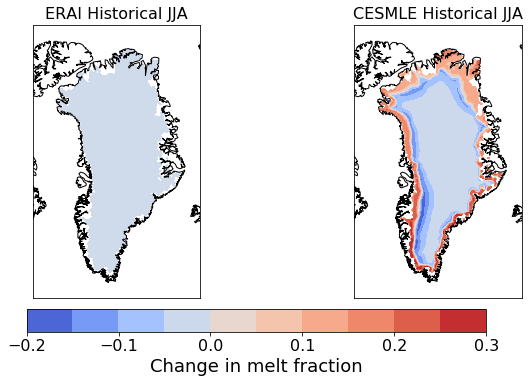

In [18]:
nModels = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
axesF = axes.flat
refMelt = meltFrac[1,:,:]
mdlIndex = (1,2)

# cLev = np.linspace( 0, nRec, 20 )
# cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    dMelt = meltFrac[mdlIndex[index],:,:] - refMelt
    cs = m.contourf(x, y, dMelt, 10, cmap = plt.get_cmap("coolwarm"), norm=MidpointNormalize(midpoint=0.))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Change in melt fraction', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_historical_diff" )

Obs + Future only: Plot melt sum, i.e., how many days did melt occur
---

Saving figure to wrf_amsmelt_tas_meltSum_future_cn.eps


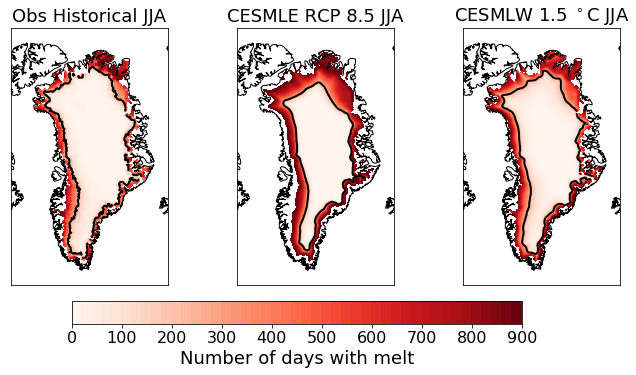

In [25]:
doCN = 1  # add single contour?
cLev2 = 230
nModels = meltSum2.shape[0]
mdlIndex = (0,3,4)
meltSum2 = meltSum[mdlIndex,:,:]
meltFrac2 = meltFrac[mdlIndex,:,:]
nModels = meltSum2.shape[0]

fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds"))
    if doCN:
        cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Number of days with melt', axes )

if doCN:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_future"+cnSuff )
else:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_future" )

Show differences
---

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


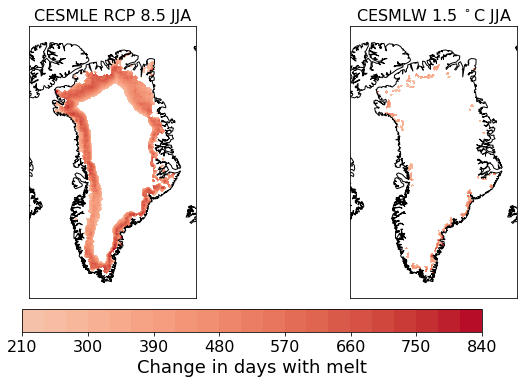

In [33]:
nModels = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
axesF = axes.flat
refMelt = meltSum[0,:,:]
mdlIndex = (3,4)

# cLev = np.linspace( 0, nRec, 20 )
# cLev = np.arange( 0, nRec, 20 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    dMelt = meltSum[mdlIndex[index],:,:] - refMelt
    nodata = (dMelt < 230)
    dMelt[nodata] = np.nan
    cs = m.contourf(x, y, dMelt, 20, cmap = plt.get_cmap("coolwarm"), norm=MidpointNormalize(midpoint=0.))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Change in days with melt', axes )
# P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_future_diff" )

Obs + Future only: Plot melt fraction, i.e., what fraction of period did melt occur
---

Saving figure to wrf_amsmelt_tas_meltFrac_future_cn.eps


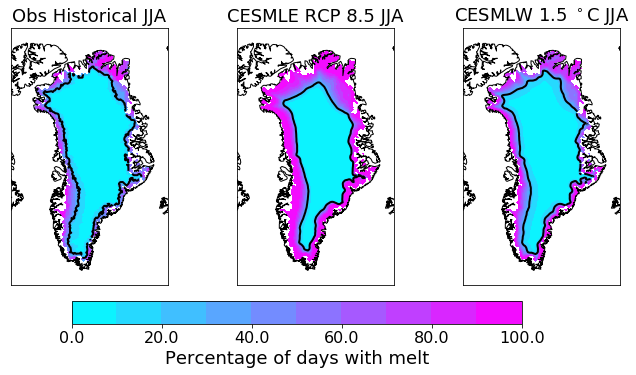

In [108]:
doCN = 1  # add single contour?
nModels = meltSum2.shape[0]
mdlIndex = (0,3,4)
cLev2 = 25.
fig, axes = plt.subplots(nrows=1, ncols=nModels, figsize=(3*nModels,2*nModels))
axesF = axes.flat

# cLev = np.linspace( 0., np.nanmax( meltFrac), 20 )
cLev = np.linspace( 0., 100., 11 )
for index in range(nModels):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("cool"))
    if doCN:
        cn = m.contour(x, y, meltFrac[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ), fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Percentage of days with melt', axes, 'bottom', "%0.1f" )

if doCN:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future"+cnSuff )
else:
    P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future" )

Show differences
---

Saving figure to wrf_amsmelt_tas_meltFrac_future_diff.eps


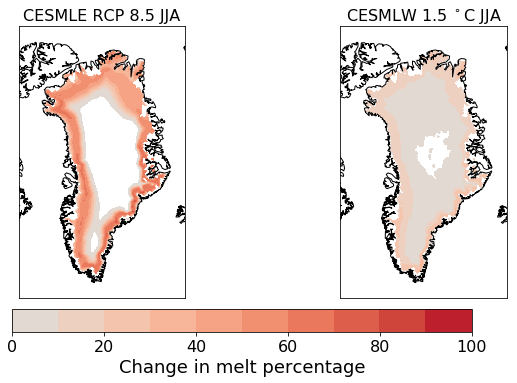

In [112]:
nModels = 2
mdlIndex = (3,4)
refMelt = meltFrac[1,:,:]
dMeltFrac = np.empty( [2, nLat, nLon] )
dMeltFrac[0,:,:] = meltFrac[mdlIndex[0],:,:] - refMelt
dMeltFrac[1,:,:] = meltFrac[mdlIndex[1],:,:] - refMelt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
axesF = axes.flat

# cLev = np.linspace( 0., np.nanmax( dMeltFrac ), 5 )
cLev = np.linspace( 0., 100., 11 )
for index in range( nModels ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    dMelt = dMeltFrac[index,:,:]
#     nodata = (dMelt < 0.25)
#     dMelt[nodata] = np.nan
    cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("coolwarm"), norm=MidpointNormalize(midpoint=0.))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=16);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Change in melt percentage', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff" )

Show series of differences: CESM LE RCP8.5
---

Saving figure to wrf_amsmelt_tas_meltFrac_future_diff_le.eps


/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less


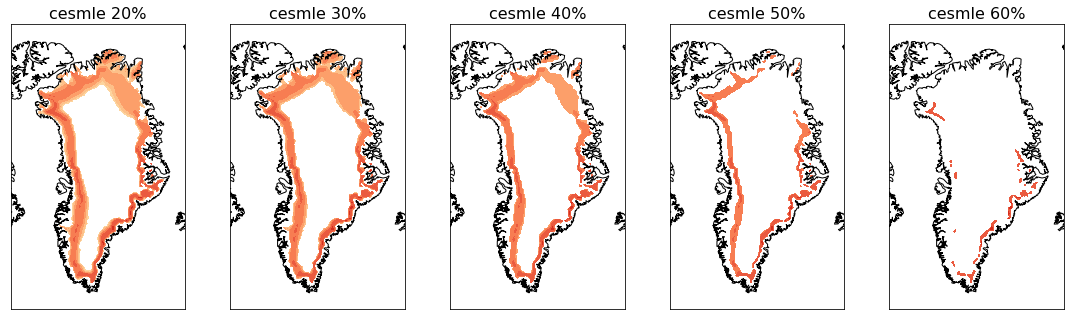

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,6))
axesF = axes.flat

refMelt = meltFrac[1,:,:]
mdlIndex = (3,4)
r = 0
mdl = mdlIndex[r]

threshList = ( 20., 30., 40., 50., 60. )
cLev = np.linspace( 0., 100., 11 )
index = 0
lowerThresh = 0.
for thresh in threshList:
    tstr = "%.0f%%" % thresh
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();

    dMelt = np.copy(dMeltFrac[r,:,:])
#         nodata = (dMelt < lowerThresh)
#         dMelt[nodata] = np.nan
#         nodata = (dMelt > thresh)
#         dMelt[nodata] = np.nan
    nodata = (dMelt < thresh)
    dMelt[nodata] = np.nan

#     cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("YlOrRd"), norm=MidpointNormalize(midpoint=0))
    cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("OrRd"))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( models[mdl]+" "+tstr,  fontsize=16);
    index += 1
    lowerThresh = thresh

plt.tight_layout( w_pad=4, h_pad=0.05 )    

# createColorBar( cs, 'Change in melt fraction', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff_le" )

Show series of differences: CESM LW
---

Saving figure to wrf_amsmelt_tas_meltFrac_future_diff_lw.eps


/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less


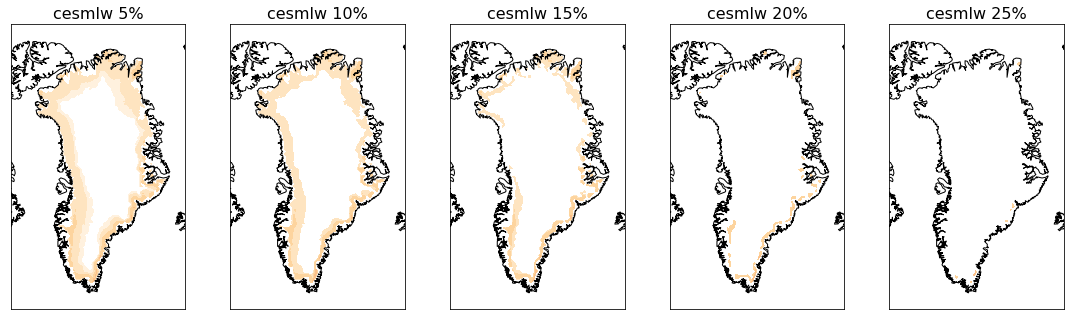

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,6))
axesF = axes.flat

refMelt = meltFrac[1,:,:]
mdlIndex = (3,4)
r = 1
mdl = mdlIndex[r]

threshList = ( 5., 10., 15., 20., 25. )
cLev = np.linspace( 0., 100., 11 )
index = 0
lowerThresh = 0.
for thresh in threshList:
    tstr = "%.0f%%" % thresh
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();

    dMelt = np.copy(dMeltFrac[r,:,:])
#         nodata = (dMelt < lowerThresh)
#         dMelt[nodata] = np.nan
#         nodata = (dMelt > thresh)
#         dMelt[nodata] = np.nan
    nodata = (dMelt < thresh)
    dMelt[nodata] = np.nan

#     cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("YlOrRd"), norm=MidpointNormalize(midpoint=0))
    cs = m.contourf(x, y, dMelt, cLev, cmap = plt.get_cmap("OrRd"))
#     if doCN:
#         cn = m.contour(x, y, meltSum[mdlIndex[index],:,:], levels = [cLev2], linewidths=2, colors='k')
#     axesF[index].set_title( createTitle( models[mdlIndex[index]], branches[mdlIndex[index]], mms ),  fontsize=18);
    axesF[index].set_title( models[mdl]+" "+tstr,  fontsize=16);
    index += 1
    lowerThresh = thresh

plt.tight_layout( w_pad=4, h_pad=0.05 )    

# createColorBar( cs, 'Change in melt fraction', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_future_diff_lw" )